In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from scipy.ndimage import gaussian_filter1d
import  umap
import tqdm.auto as tqdm


In [2]:
# Load data
data = pd.read_csv('Raw Data.csv')

In [16]:
# plot stats
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Time (s),36949.0,46.108954,26.612839,0.015791,23.062561,46.109047,69.155385,92.201779
Linear Acceleration x (m/s^2),36949.0,1.994367,9.318265,-56.316448,-1.138067,0.120788,3.664738,73.355492
Linear Acceleration y (m/s^2),36949.0,-2.236733,8.131037,-48.898514,-3.972427,-0.263371,0.219369,54.292007
Linear Acceleration z (m/s^2),36949.0,0.722991,4.760631,-36.957134,-0.629315,0.091930,1.534431,68.635460
Absolute acceleration (m/s^2),36949.0,8.347797,10.743522,0.011775,0.917422,4.461435,11.787056,82.789797


In [4]:
# get column names
data.columns

Index(['Time (s)', 'Linear Acceleration x (m/s^2)',
       'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)',
       'Absolute acceleration (m/s^2)'],
      dtype='object')

In [19]:
xyz = data[['Linear Acceleration x (m/s^2)',
       'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)']]

In [20]:
acc = data['Absolute acceleration (m/s^2)']

In [21]:
t = data['Time (s)']

In [22]:
# convert to numpy array
xyz = xyz.to_numpy()
acc = acc.to_numpy()
t = t.to_numpy()

In [9]:
xyz.shape, acc.shape

((36949, 3), (36949,))

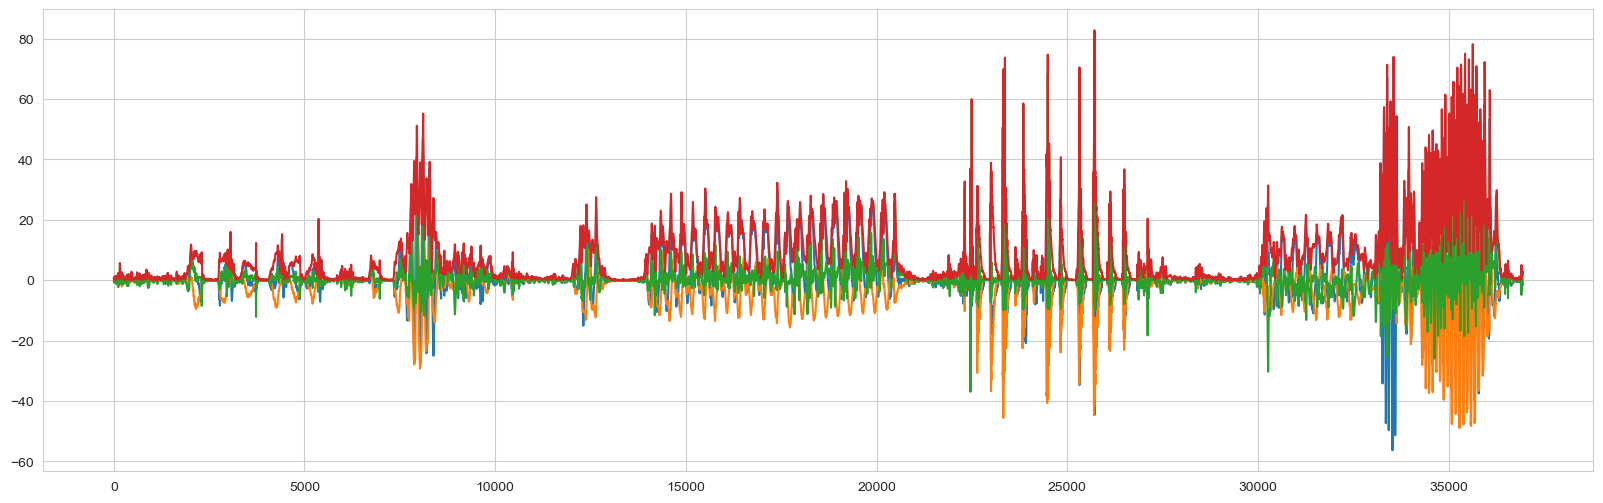

In [69]:
# plot data

plt.figure(figsize=(20, 6))

for acc_i, acc_name in zip(xyz.T, ['x', 'y', 'z']):
    plt.plot(acc_i, label=acc_name)
    
plt.plot(acc, label='abs')

plt.show()
plt.close()

In [13]:
len = len(acc)

In [25]:
sample_step = (t.max()-t.min())/len

In [26]:
sample_step

0.002494952185336545

In [38]:
std_win_len

40080

In [64]:
std_win_len_s = 0.1
std_win_len = int(std_win_len_s/sample_step)

std_win = [acc[i:i+std_win_len].std()  for i in range(len-std_win_len)]
std_win = np.array(std_win)

# 1d gaussian filter scipy
std_win_f = gaussian_filter1d(std_win, sigma=20)

(0.0, 2.0)

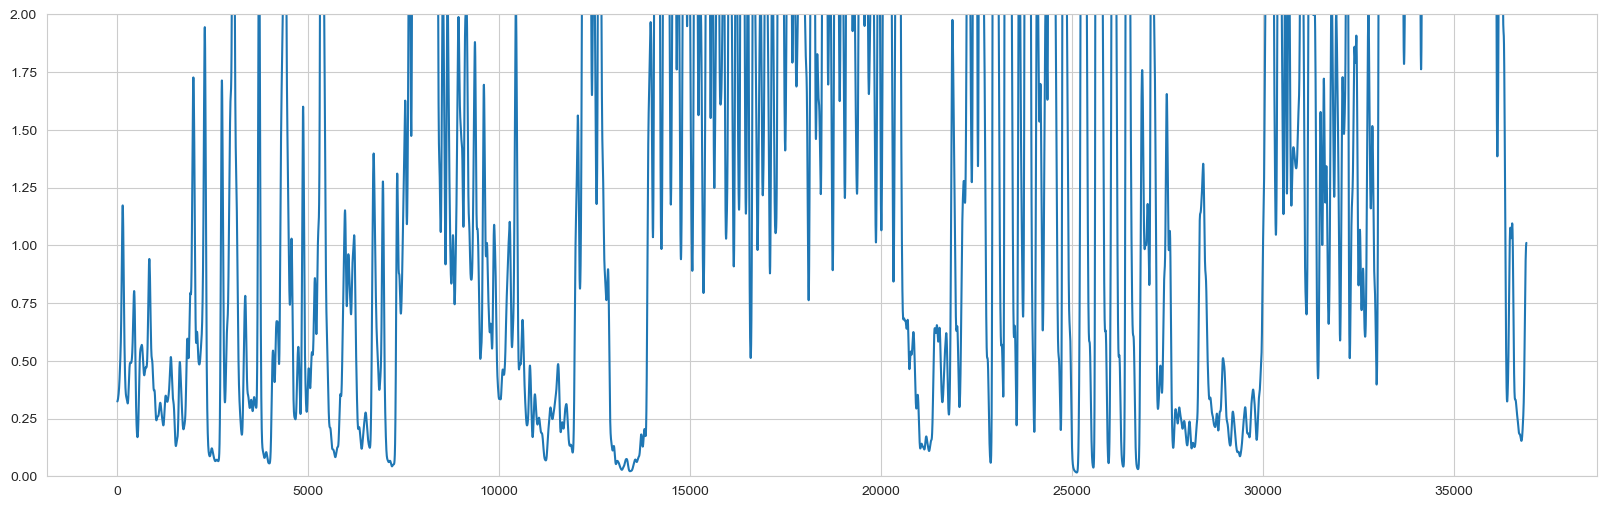

In [65]:
plt.figure(figsize=(20, 6))
plt.plot(std_win_f)
plt.ylim(0, 2)

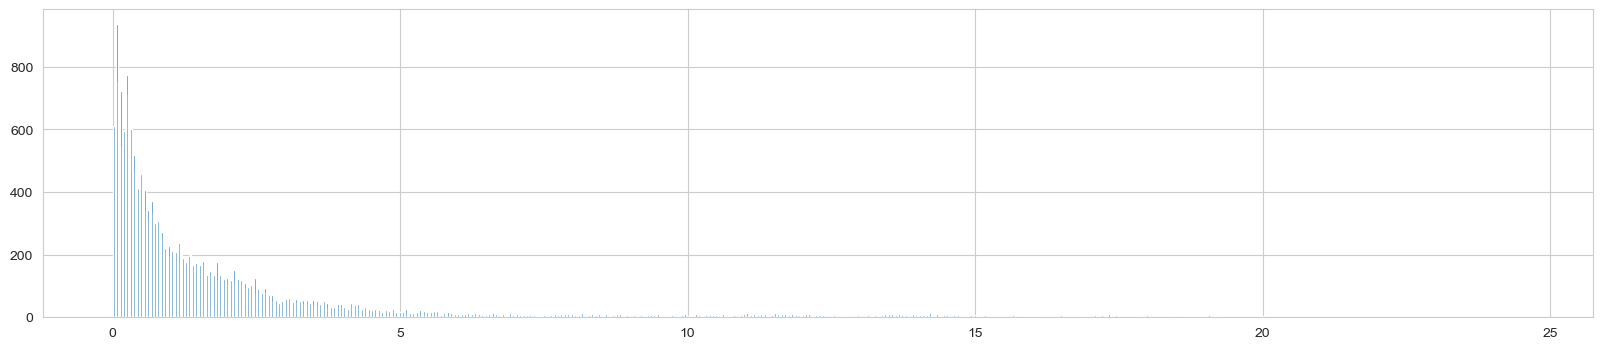

In [61]:
# plot distribution of std
plt.figure(figsize=(20, 4))
plt.hist(std_win_f, bins=1000);

In [77]:
# split data into chunks of smpl_len_ms = 500ms
smpl_len_s = .5
smpl_len = int(smpl_len_s/sample_step)

chunks_xyz = []
chunks_acc = []
chunks_t = []

for i in range(0, (len//smpl_len)*smpl_len, smpl_len):
    # print window range
    print(i, i+smpl_len)
    chunks_xyz.append(xyz[i:i+smpl_len])
    chunks_acc.append(acc[i:i+smpl_len])
    chunks_t.append(t[i:i+smpl_len])

chunks_xyz = np.array(chunks_xyz)
chunks_acc = np.array(chunks_acc)
chunks_t = np.array(chunks_t)



0 200
200 400
400 600
600 800
800 1000
1000 1200
1200 1400
1400 1600
1600 1800
1800 2000
2000 2200
2200 2400
2400 2600
2600 2800
2800 3000
3000 3200
3200 3400
3400 3600
3600 3800
3800 4000
4000 4200
4200 4400
4400 4600
4600 4800
4800 5000
5000 5200
5200 5400
5400 5600
5600 5800
5800 6000
6000 6200
6200 6400
6400 6600
6600 6800
6800 7000
7000 7200
7200 7400
7400 7600
7600 7800
7800 8000
8000 8200
8200 8400
8400 8600
8600 8800
8800 9000
9000 9200
9200 9400
9400 9600
9600 9800
9800 10000
10000 10200
10200 10400
10400 10600
10600 10800
10800 11000
11000 11200
11200 11400
11400 11600
11600 11800
11800 12000
12000 12200
12200 12400
12400 12600
12600 12800
12800 13000
13000 13200
13200 13400
13400 13600
13600 13800
13800 14000
14000 14200
14200 14400
14400 14600
14600 14800
14800 15000
15000 15200
15200 15400
15400 15600
15600 15800
15800 16000
16000 16200
16200 16400
16400 16600
16600 16800
16800 17000
17000 17200
17200 17400
17400 17600
17600 17800
17800 18000
18000 18200
18200 18400
18400 

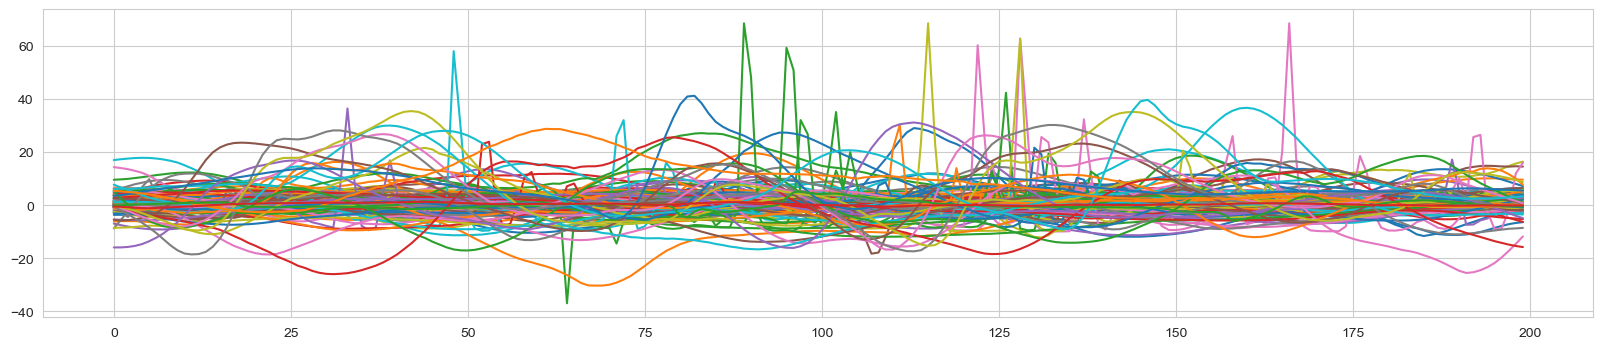

In [78]:
# plot z acceleration for each chunk

plt.figure(figsize=(20, 4))
for acc_i in chunks_xyz[:, :, 2]:
    plt.plot(acc_i)

In [79]:
chunks_xyz.shape

(184, 200, 3)

In [80]:
chuncks_flat = chunks_acc.reshape(chunks_xyz.shape[0], -1)

In [81]:
chuncks_flat.shape

(184, 200)

In [82]:
# UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(chuncks_flat)


In [83]:
embedding.shape

(184, 2)

In [84]:
chunks_t.shape

(184, 200)

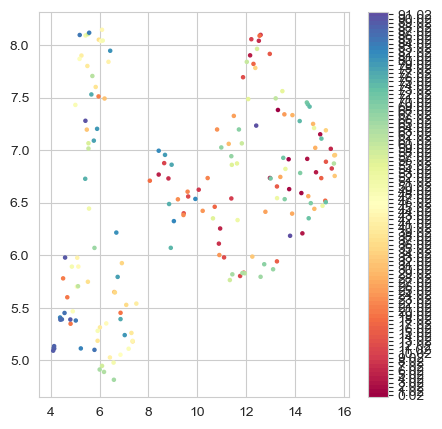

In [85]:
plt.figure(figsize=(5, 5))
plt.scatter(embedding[:, 0], embedding[:, 1], c=chunks_t[:, 0], cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(chunks_t[:, 0].min(), chunks_t[:, 0].max()+1)-0.5).set_ticks(np.arange(chunks_t[:, 0].min(), chunks_t[:, 0].max()))

# multipe sections

In [86]:
# read four data files
data_blocks = [pd.read_csv(f'Raw Data_{i}.csv') for i in range(1, 5)]

In [206]:
# make chunks for each block
chunks_xyz = []
chunks_acc = []
chunks_t = []
chunks_class = []

smpl_len_s = .5
smpl_len = int(smpl_len_s/sample_step)

for c, data in enumerate(data_blocks):
    xyz = data[['Linear Acceleration x (m/s^2)',
           'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)']]
    acc = data['Absolute acceleration (m/s^2)']

    t = data['Time (s)']
    
    xyz = xyz.to_numpy()
    acc = acc.to_numpy()
    t = t.to_numpy()
    
    l = len(acc)
    
    for i in range(0, (l//smpl_len)*smpl_len, smpl_len):
        # print window range
        chunks_xyz.append(xyz[i:i+smpl_len])
        chunks_acc.append(acc[i:i+smpl_len])
        chunks_t.append(t[i:i+smpl_len])
        
        chunks_class.append(c)
        
chunks_xyz = np.array(chunks_xyz)
chunks_acc = np.array(chunks_acc)
chunks_t = np.array(chunks_t)
chunks_class = np.array(chunks_class)

In [207]:
chunks_xyz.shape, chunks_acc.shape, chunks_t.shape, chunks_class.shape

((136, 200, 3), (136, 200), (136, 200), (136,))

In [208]:
chuncks_flat = chunks_xyz.reshape(chunks_xyz.shape[0], -1)
chuncks_flat.shape

(136, 600)

In [209]:
# UMAP
reducer = umap.UMAP()
embedding1 = reducer.fit_transform(chuncks_flat)

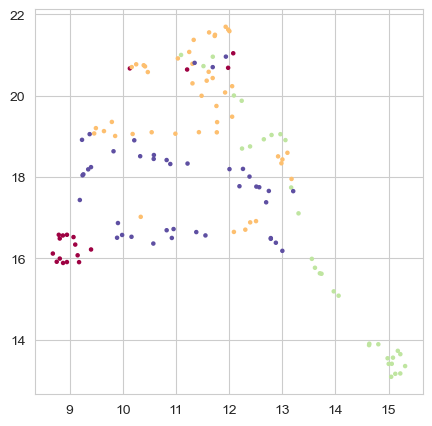

In [210]:
plt.figure(figsize=(5, 5))
plt.scatter(embedding1[:, 0], embedding1[:, 1], c=chunks_class, cmap='Spectral', s=5)

In [211]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(chuncks_flat, chunks_class, test_size=0.2, random_state=42)

In [212]:
# make a NN with 4 class classification, 3*smpl_len input, hidden layer with 100 and 16 neurons, output layer with 4 neurons
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3*smpl_len, 100)
        self.fc2 = nn.Linear(100, 16)
        self.fc3 = nn.Linear(16, 4)
        
    def repr(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x

    def forward(self, x):
        x = self.repr(x)
        x = self.fc3(x)
        
        return x
    
    def predict(self, x):
        x = self.forward(x)
        
        #torch argmax
        return torch.argmax(x, dim=1).detach().cpu().numpy()

In [213]:

# instantiate the model
model = Net()

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 100
# torch tesnor dataset
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

# data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# train the model
epochs = 100

for ep_idx in tqdm.tqdm(range(epochs)):
    # get random batch
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
    # evaluate on test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

  0%|          | 0/100 [00:00<?, ?it/s]

In [214]:
pred= model.predict(torch.tensor(X_test, dtype=torch.float32))

In [215]:
# confusion matrix
cm = confusion_matrix(y_test, pred)

In [216]:
cm

array([[ 3,  0,  0,  1],
       [ 0, 13,  0,  0],
       [ 0,  1,  4,  0],
       [ 0,  2,  0,  4]], dtype=int64)

In [217]:
# evaluate on test set classification report

In [218]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.81      1.00      0.90        13
           2       1.00      0.80      0.89         5
           3       0.80      0.67      0.73         6

    accuracy                           0.86        28
   macro avg       0.90      0.80      0.84        28
weighted avg       0.87      0.86      0.85        28


In [219]:
# get the representation of the data for all dataset
model.eval()
with torch.no_grad():
    repr = model.repr(torch.tensor(chuncks_flat, dtype=torch.float32)).detach().cpu().numpy()
    
print(repr.shape)

(136, 16)


In [220]:
# UMAP
reducer = umap.UMAP()
embedding2 = reducer.fit_transform(repr)

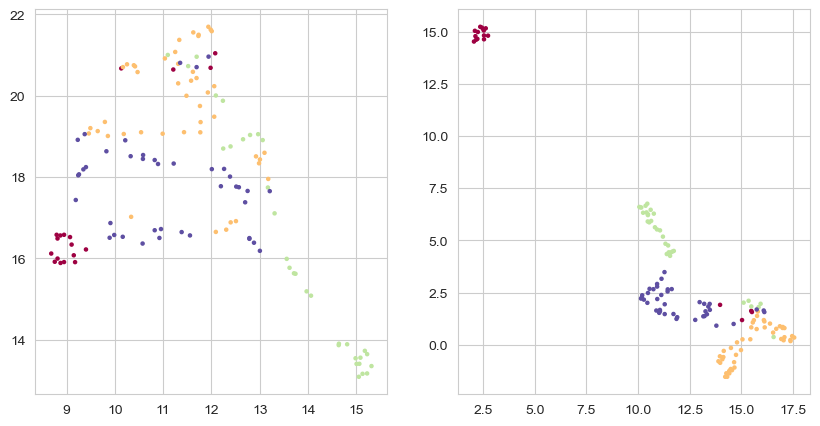

In [221]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(embedding1[:, 0], embedding1[:, 1], c=chunks_class, cmap='Spectral', s=5)
ax[1].scatter(embedding2[:, 0], embedding2[:, 1], c=chunks_class, cmap='Spectral', s=5)
plt.show()
plt.close()